# Data Importing

In [1]:
#Import The required Python libraries.
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from skimage import io, transform
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping,CSVLogger,ProgbarLogger
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.regularizers import l2
import time


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**Changable_Parameter**

In [3]:
#here image size is 256x256
IMAGE_SIZE = 256
#every time process 32 images (61x31)~1951
batch_size = 20
#how many color have in these pictures
CHANNELS = 3
#80x25~1951
EPOCHS = 50
NUM_CLASSES = 4
input_shape = (batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
patience=10
data_dir ="C:\\Users\\akton\\Documents\\CPASTONE\\New folder2"
split_folder="C:\\Users\\akton\\Documents\\CPASTONE\\splitted"
model_name="resnet50"  

**Directory Creation and split**

In [9]:
import os
import shutil
import random
import math

# Example paths

train_val_dir = os.path.join(split_folder, "train_validation_data")
test_dir = os.path.join(split_folder, "test_data")

def split_data(source_folder, split_folder, train_val_ratio=0.9):
    # Check if split folders already exist
    if os.path.exists(train_val_dir) and os.path.exists(test_dir):
        print("Split folders already exist. Skipping data split.")
        return
    
    # Create split folders if they do not exist
    if not os.path.exists(split_folder):
        os.makedirs(split_folder)
    if not os.path.exists(train_val_dir):
        os.makedirs(train_val_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
    
    # Count variables
    train_val_count = 0
    test_count = 0
    
    # Iterate through source_folder (main folder with classes)
    for class_folder in os.listdir(source_folder):
        class_path = os.path.join(source_folder, class_folder)
        
        if os.path.isdir(class_path):
            # Create corresponding folders in split_folder
            train_val_class_path = os.path.join(train_val_dir, class_folder)
            test_class_path = os.path.join(test_dir, class_folder)
            
            if not os.path.exists(train_val_class_path):
                os.makedirs(train_val_class_path)
            if not os.path.exists(test_class_path):
                os.makedirs(test_class_path)
            
            # List all images in the class folder
            images = [img for img in os.listdir(class_path) if img.endswith('.jpg') or img.endswith('.png')]
            random.shuffle(images)
            
            # Calculate split indices
            split_index = int(len(images) * train_val_ratio)
            
            # Split images into train_validation_data and test_data
            train_val_images = images[:split_index]
            test_images = images[split_index:]
            
            # Copy images to respective split folders
            for img in train_val_images:
                src = os.path.join(class_path, img)
                dst = os.path.join(train_val_class_path, img)
                shutil.copy(src, dst)
                train_val_count += 1
                
            for img in test_images:
                src = os.path.join(class_path, img)
                dst = os.path.join(test_class_path, img)
                shutil.copy(src, dst)
                test_count += 1
    
    print("Data split completed successfully.")
    print(f"Number of images in train_validation_data: {train_val_count}")
    print(f"Number of images in test_data: {test_count}")
    print(f"Total number of images: {train_val_count + test_count}")

# Call the function with your paths
split_data(data_dir, split_folder)


Split folders already exist. Skipping data split.


In [10]:
import os
import shutil
import random
import tensorflow as tf
# Define image parameters

# Define data augmentation parameters
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.10+.03,  # 10% of the data will be used for validation
)

train_generator = datagen.flow_from_directory(
    train_val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='categorical',  # Update for multi-class classification
    subset='training'  # specify that this generator will be used for training data
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


validation_generator = datagen.flow_from_directory(
    train_val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='categorical',  # Update for multi-class classification
    subset='validation'  # specify that this generator will be used for validation data
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
    class_mode='categorical'  # Update for multi-class classification
)


Found 4136 images belonging to 4 classes.
Found 616 images belonging to 4 classes.
Found 528 images belonging to 4 classes.


In [11]:
import os
import random
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import load_model
import numpy as np

In [12]:
# Load the models
model1 = load_model('C:\\Users\\akton\\Documents\\CPASTONE\\dense201\\densenet201.h5')
model2 = load_model('C:\\Users\\akton\\Documents\\CPASTONE\\Resnet50\\resnet50.h5')
model3 = load_model('C:\\Users\\akton\\Documents\\CPASTONE\\inception v3\\InceptionV3.h5')

def voting_ensemble(models, test_data):
    # Get the predictions from all models
    predictions = [model.predict(test_data) for model in models]
    
    # Average the predictions (soft voting)
    avg_pred = np.mean(predictions, axis=0)
    
    # Convert the probabilities to class predictions
    predicted_classes = np.argmax(avg_pred, axis=1)
    
    # True classes
    true_classes = test_data.classes
    
    # Classification report
    report = classification_report(true_classes, predicted_classes)
    
    # Accuracy
    accuracy = accuracy_score(true_classes, predicted_classes)
    
    return report, accuracy

def bagging_ensemble(models, test_data):
    # Same approach as voting but can simulate bootstrapping here
    return voting_ensemble(models, test_data)  # Reusing the voting code

# Apply voting ensemble
voting_report, voting_accuracy = voting_ensemble([model1, model2, model3], test_generator)
print("Voting Classification Report:")
print(voting_report)
print("Voting Accuracy:", voting_accuracy)

# Apply bagging ensemble
bagging_report, bagging_accuracy = bagging_ensemble([model1, model2, model3], test_generator)
print("Bagging Classification Report:")
print(bagging_report)
print("Bagging Accuracy:", bagging_accuracy)

Voting Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.30      0.28       132
           1       0.23      0.25      0.24       132
           2       0.19      0.16      0.17       132
           3       0.19      0.19      0.19       132

    accuracy                           0.22       528
   macro avg       0.22      0.22      0.22       528
weighted avg       0.22      0.22      0.22       528

Voting Accuracy: 0.22348484848484848
Bagging Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.27      0.26       132
           1       0.26      0.24      0.25       132
           2       0.23      0.20      0.22       132
           3       0.21      0.22      0.21       132

    accuracy                           0.23       528
   macro avg       0.24      0.23      0.23       528
weighted avg       0.24      0.23      0.23       528

Bagging Accuracy: 0.234848484848

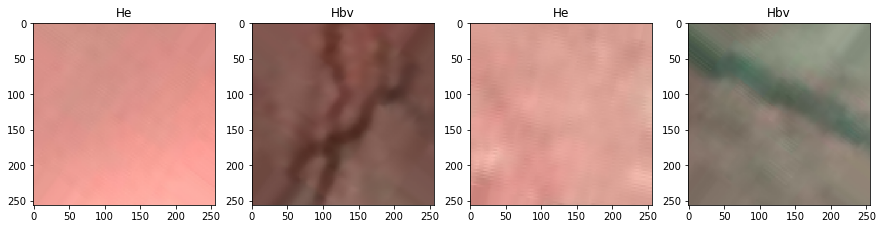

In [7]:
images, labels = next(train_generator)

# Plot four random images from the batch
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    # Generate a random index
    random_index = np.random.randint(0, batch_size)
    
    # Plot the image
    axes[i].imshow(images[random_index])
    
    # Get the corresponding label
    label = labels[random_index]
    
    # Set the title as the class name
    class_name = train_generator.class_indices
    axes[i].set_title(list(class_name.keys())[np.argmax(label)])

plt.show()

# Building model

In [8]:
from tensorflow.keras.applications import Xception,InceptionV3,NASNetMobile,DenseNet201

model= Xception(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
                 )

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in model.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 Activation False
4 Conv2D False
5 BatchNormalization False
6 Activation False
7 SeparableConv2D False
8 BatchNormalization False
9 Activation False
10 SeparableConv2D False
11 BatchNormalization False
12 Conv2D False
13 MaxPooling2D False
14 BatchNormalization False
15 Add False
16 Activation False
17 SeparableConv2D False
18 BatchNormalization False
19 Activation False
20 SeparableConv2D False
21 BatchNormalization False
22 Conv2D False
23 MaxPooling2D False
24 BatchNormalization False
25 Add False
26 Activation False
27 SeparableConv2D False
28 BatchNormalization False
29 Activation False
30 SeparableConv2D False
31 BatchNormalization False
32 Conv2D False
33 MaxPooling2D False
34 BatchNormalization False
35 Add False
36 Activation False
37 SeparableConv2D False
38 BatchNormalization False
39 Activation False
40 SeparableConv2D False
41 BatchNormalization False
42 Activation False
43 SeparableConv2D False
44 BatchNormaliz

**Fine Tuning**

In [9]:
for layer in model.layers[:95]:
   layer.trainable = False
for layer in model.layers[95:]:
   layer.trainable = True

# print('Last block of the conv_base is now trainable')


for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d False
13 block2_pool False
14 batch_normalization False
15 add False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_1 False
23 block3_pool False
24 batch_normalization_1 False
25 add_1 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_2 False
33 block4_pool False
34 batch_normalization_2 False
35 add_2 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepconv2 False

In [10]:

def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed on top of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu',kernel_regularizer=l2(0.01))(top_model)  # Adding L2 regularization
    top_model = Dropout(0.6)(top_model) 
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model


In [11]:
from keras.models import Model
FC_Head = lw(model, NUM_CLASSES)
model = Model(inputs = model.input, outputs = FC_Head)


# Training

In [12]:
from tensorflow.keras.callbacks import LearningRateScheduler


def scheduler(epoch, lr):
     if epoch < 5:
         return .002
     else:
        return .002

lr_scheduler = LearningRateScheduler(scheduler)

In [13]:
if not os.path.exists("Results"):
    os.makedirs("Results")
if not os.path.exists("Model"):
    os.makedirs("Model") 
csv_logger_path = os.path.join("Results", f"{model_name}_results.csv")
model_checkpoint_path = os.path.join("Model", f"{model_name}_Model.hdf5")

**CheckPoints**

In [14]:

csv_logger = CSVLogger(csv_logger_path)
early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
check = ModelCheckpoint(model_checkpoint_path, verbose=1, save_best_only=True)
progbar_logger = ProgbarLogger()

In [15]:

training_time = time.time()
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
history = model.fit(train_generator,
                    epochs=50, 
                    batch_size=batch_size,
                    validation_data=validation_generator,
                    verbose = 1,
                    callbacks = [early_stopping,lr_scheduler,check,csv_logger],
                    initial_epoch=0)

Epoch 1/50
207/207 [==============================] - 42s 146ms/step - loss: 1.1296 - accuracy: 0.9079 - val_loss: 0.1801 - val_accuracy: 0.9692

Epoch 00001: val_loss improved from inf to 0.18014, saving model to Model\resnet50_Model.hdf5


C:\Users\akton\.conda\envs\ev2\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
207/207 [==============================] - 22s 106ms/step - loss: 0.2771 - accuracy: 0.9662 - val_loss: 0.2867 - val_accuracy: 0.9529

Epoch 00002: val_loss did not improve from 0.18014
Epoch 3/50
207/207 [==============================] - 22s 106ms/step - loss: 0.2739 - accuracy: 0.9691 - val_loss: 0.1765 - val_accuracy: 0.9821

Epoch 00003: val_loss improved from 0.18014 to 0.17647, saving model to Model\resnet50_Model.hdf5
Epoch 4/50
207/207 [==============================] - 22s 106ms/step - loss: 0.2261 - accuracy: 0.9778 - val_loss: 0.1689 - val_accuracy: 0.9984

Epoch 00004: val_loss improved from 0.17647 to 0.16893, saving model to Model\resnet50_Model.hdf5
Epoch 5/50
207/207 [==============================] - 22s 107ms/step - loss: 0.1606 - accuracy: 0.9848 - val_loss: 0.0733 - val_accuracy: 0.9951

Epoch 00005: val_loss improved from 0.16893 to 0.07331, saving model to Model\resnet50_Model.hdf5
Epoch 6/50
207/207 [==============================] - 22s 106ms/step - 

In [16]:
# Calculate the total training time
total_time = time.time() - training_time
# Convert total time into minutes and seconds
minutes = total_time // 60
seconds = total_time % 60
print(f"Total Training Time: {int(minutes)} minutes and {seconds:.2f} seconds")

Total Training Time: 44 minutes and 37.83 seconds


**saving models**

In [17]:
import pickle

pickle_path_json = os.path.join("Results", f"{model_name}_model_architecture.json")
pickle_model_path = os.path.join("Model", f"{model_name}_model_pickle.pkl")

# Save model architecture to JSON (only needed once)
model_architecture = model.to_json()
with open(pickle_path_json, 'w') as f:
    f.write(model_architecture)

# Save model weights using pickle
with open(pickle_model_path, 'wb') as f:
    pickle.dump(model, f)

AttributeError: Can't pickle local object 'Layer.add_loss.<locals>._tag_callable'

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [19]:
model.save(model_name)


INFO:tensorflow:Assets written to: resnet50\assets


C:\Users\akton\.conda\envs\ev2\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [20]:
model.save(f'{model_name}.h5')

In [21]:
# model.save(f'{model_name}.h5')

model_name = 'my_model'
try:
    model.save(f'{model_name}.h5')
    print(f"Model saved as {model_name}.h5")
except Exception as e:
    print(f"Error saving model: {e}")

Model saved as my_model.h5


In [49]:
# model = tf.keras.models.load_model(f'{model_name}_.h5')

In [50]:
# history_path = os.path.join("Results", f"{model_name}__training_history.xlsx")
# import pandas as pd
# history_df = pd.DataFrame(history_path.history)
# history_df.to_excel(history_path, index=False)

# Result

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

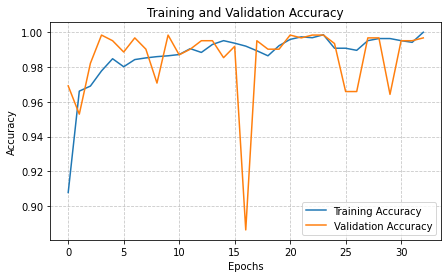

In [23]:

plt.figure(figsize=(7, 4))
plt.plot((epochs ), history.history['accuracy'], label='Training Accuracy')
plt.plot((epochs ), history.history['val_accuracy'], label='Validation Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

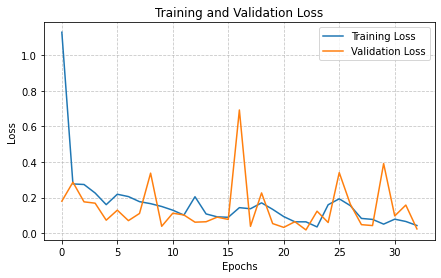

In [24]:
plt.figure(figsize=(7, 4))
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
        

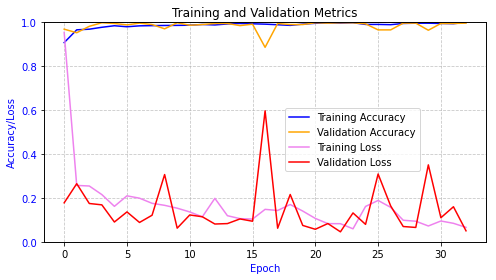

In [25]:
import matplotlib.pyplot as plt

# Assuming the following are defined:
# epochs: list of epoch numbers (e.g., [1, 2, 3, ..., num_epochs])
# history: training history object containing 'accuracy', 'val_accuracy', 'loss', and 'val_loss' metrics

fig, ax1 = plt.subplots(figsize=(7, 4))

# Plot Training and Validation Accuracy
ax1.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='blue')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='orange')

# Set y-axis label and limits for accuracy
ax1.set_ylabel('Accuracy/Loss', color='blue')
ax1.set_xlabel('Epoch', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim([0, 1])  # Limit y-axis for accuracy between 0 and 1

# Create a second y-axis for loss
ax2 = ax1.twinx()
ax2.plot(epochs, history.history['loss'], label='Training Loss', color='violet')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss', color='red')

# Hide y-axis ticks and labels for loss
ax2.set_yticks([])  # Remove y-axis ticks
ax2.set_ylabel('')  # Set empty string to hide the label

# Add grid, legends, title, and x-axis label
ax1.grid(True, linestyle='--', alpha=0.7)

# Combine legends for accuracy and loss in the middle right
handles, labels = [], []
for ax in [ax1, ax2]:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Adjust legend position to be slightly left of center right
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.85, 0.5))

plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')

# Show plot
plt.tight_layout()
plt.show()


In [26]:
score = model.evaluate(test_generator ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

27/27 [==============================] - 3s 88ms/step - loss: 0.0226 - accuracy: 0.9962
Test Loss: 0.022561995312571526
Test accuracy: 99.62121248245239


In [27]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix

# Initialize empty lists to store true and predicted labels
y_true_all = []
y_pred_all = []

# Loop through all batches in the validation generator
for i in range(len(test_generator)):
    # Get the next batch of data
    x_val, y_val = test_generator[i]
    
    # Predict labels for the batch
    y_pred_prob = model.predict(x_val)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Append true and predicted labels to the lists
    y_true_all.extend(np.argmax(y_val, axis=1))
    y_pred_all.extend(y_pred)

# Convert lists to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Generate classification report
report = classification_report(y_true_all, y_pred_all, target_names=class_labels, zero_division=1,digits=4)



In [28]:
print(report)

              precision    recall  f1-score   support

         Hbv     0.9851    1.0000    0.9925       132
          He     1.0000    1.0000    1.0000       132
        IPCL     1.0000    0.9848    0.9924       132
          Le     1.0000    1.0000    1.0000       132

    accuracy                         0.9962       528
   macro avg     0.9963    0.9962    0.9962       528
weighted avg     0.9963    0.9962    0.9962       528



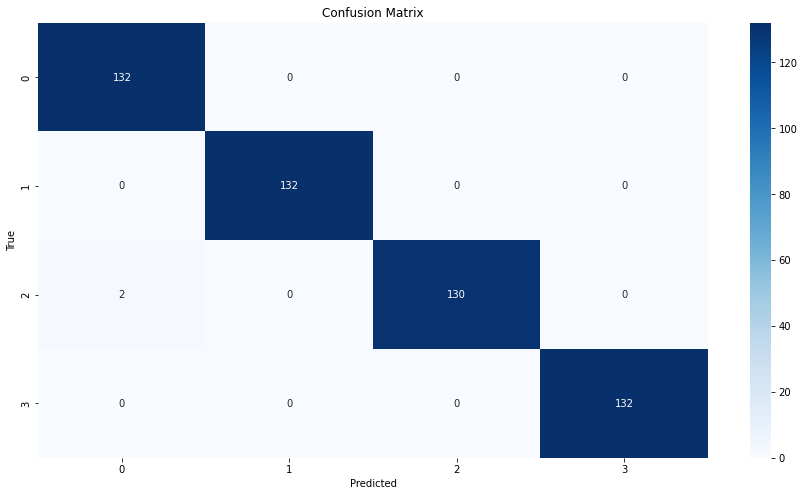

In [29]:
cm = confusion_matrix(y_true_all, y_pred_all)
import seaborn as sns
# Get class labels
class_labels = list(validation_generator.class_indices.keys())
#sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
# Plot confusion matrix
plt.figure(figsize=(15, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

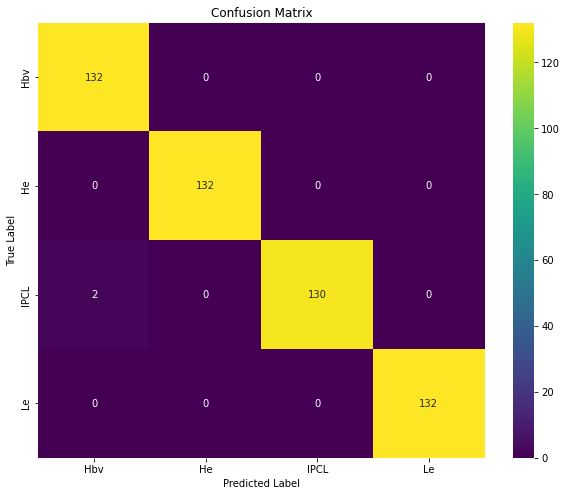

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Plot confusion matrix with a colorful palette
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='viridis', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [31]:
start_time = time.time()
predicted_vals = model.predict(test_generator, steps = len(test_generator))
predicted_vals.shape  # number of test samples x number of classes to predict
total_inf_time = time.time() - start_time

minutes = total_inf_time // 60
seconds = total_inf_time % 60

# Average inference time per sample
average_inference_time = total_time / test_generator.samples
avg_minutes = average_inference_time // 60
avg_seconds = average_inference_time % 60

print(f"Total Inference Time for {test_generator.samples} samples: {int(minutes)} minutes and {seconds:.2f} seconds")
print(f"Average Inference Time per sample: {int(avg_minutes)} minutes and {avg_seconds:.2f} seconds")

Total Inference Time for 528 samples: 0 minutes and 2.44 seconds
Average Inference Time per sample: 0 minutes and 5.07 seconds


In [32]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Initialize empty lists to store true and predicted labels
y_true_all = []
y_pred_all = []

# Loop through all batches in the validation generator
for i in range(len(test_generator)):
    # Get the next batch of data
    x_val, y_val = test_generator[i]
    
    # Predict labels for the batch
    y_pred_prob = model.predict(x_val)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Append true and predicted labels to the lists
    y_true_all.extend(np.argmax(y_val, axis=1))
    y_pred_all.extend(y_pred)

# Convert lists to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true_all, y_pred_all)

# Calculate specificity for each class
specificity = {}
for i, label in enumerate(class_labels):
    # True Negatives (TN) are all the elements except the row and column of the class i
    tn = np.sum(conf_matrix) - (np.sum(conf_matrix[i, :]) + np.sum(conf_matrix[:, i]) - conf_matrix[i, i])
    # False Positives (FP) are the sum of the i-th column except the i-th element
    fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    specificity[label] = tn / (tn + fp)



# # Optionally, you can also print the confusion matrix
# print("\nConfusion Matrix:")
# print(conf_matrix)


In [33]:
# Print specificity for each class
for class_label in class_labels:
    print(f"Specificity for class '{class_label}': {specificity[class_label]:.4f}")

Specificity for class 'Hbv': 0.9949
Specificity for class 'He': 1.0000
Specificity for class 'IPCL': 1.0000
Specificity for class 'Le': 1.0000


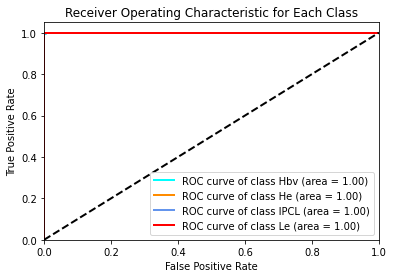

In [34]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Initialize empty lists to store true and predicted labels
y_true_all = []
y_pred_all = []
y_pred_prob_all = []

# Loop through all batches in the validation generator
for i in range(len(test_generator)):
    # Get the next batch of data
    x_val, y_val = test_generator[i]
    
    # Predict labels for the batch
    y_pred_prob = model.predict(x_val)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Append true and predicted labels to the lists
    y_true_all.extend(np.argmax(y_val, axis=1))
    y_pred_all.extend(y_pred)
    y_pred_prob_all.extend(y_pred_prob)

# Convert lists to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)
y_pred_prob_all = np.array(y_pred_prob_all)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Binarize the output
from sklearn.preprocessing import label_binarize
n_classes = len(test_generator.class_indices)
y_true_bin = label_binarize(y_true_all, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob_all[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_labels[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc="lower right")
plt.show()


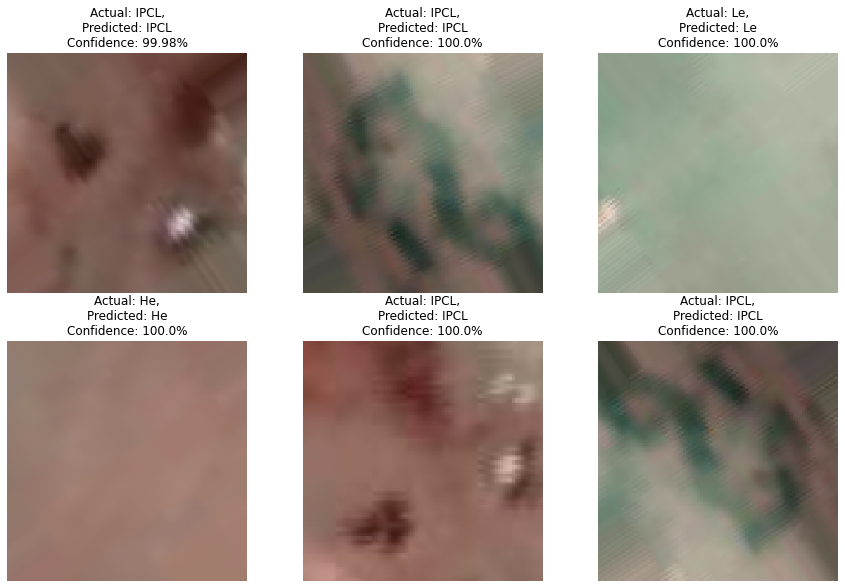

In [35]:
class_names = list(test_generator.class_indices.keys())

# Define the predict function
def predict(model, img):
    # Convert the image to a NumPy array
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Add an extra dimension to the array to match the model's expected input shape
    img_array = tf.expand_dims(img_array, 0)

    # Use the model to make predictions on the image
    predictions = model.predict(img_array)

    # Find the index of the class with the highest probability
    predicted_class = class_names[np.argmax(predictions[0])]

    # Get the confidence level of the prediction (probability of the predicted class)
    confidence = round(100 * np.max(predictions[0]), 2)

    # Return the predicted class and confidence level
    return predicted_class, confidence

# Select random images and plot them
plt.figure(figsize=(15, 15))
random_indices = np.random.choice(len(test_generator), 6, replace=False)

for i, idx in enumerate(random_indices):
    # Get the next batch of data
    x_val, y_val = test_generator[idx]
    
    # Select a random image from the batch
    random_image_index = np.random.randint(x_val.shape[0])
    img = x_val[random_image_index]
    actual_class = class_names[np.argmax(y_val[random_image_index])]

    # Predict the class and confidence
    predicted_class, confidence = predict(model, img)

    # Plot the image
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f'Actual: {actual_class},\nPredicted: {predicted_class}\nConfidence: {confidence}%')
    plt.axis('off')

plt.show()

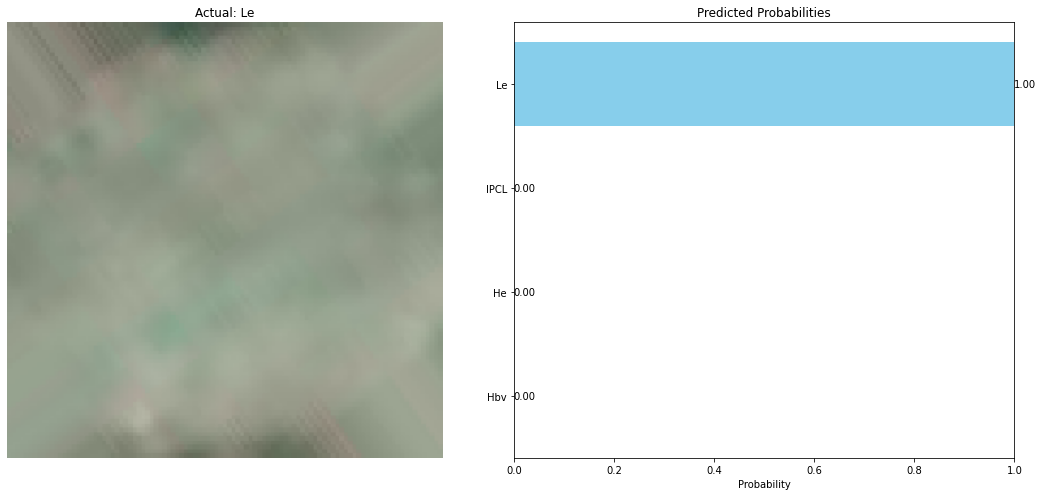

In [36]:
def predict_probabilities(model, img):
    # Convert the image to a NumPy array
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Add an extra dimension to the array to match the model's expected input shape
    img_array = tf.expand_dims(img_array, 0)

    # Use the model to make predictions on the image
    predictions = model.predict(img_array)

    # Get the probability scores for each class
    probabilities = predictions[0]

    return probabilities

# Select one image from the test generator
x_val, y_val = next(validation_generator)
img = x_val[0]
actual_class = class_names[np.argmax(y_val[0])]

# Predict the probabilities for the image
probabilities = predict_probabilities(model, img)

# Plot the image and the probabilities
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f'Actual: {actual_class}')
plt.axis('off')

plt.subplot(1, 2, 2)
bars = plt.barh(class_names, probabilities, color='skyblue')
plt.xlim([0, 1])
plt.xlabel('Probability')
plt.title('Predicted Probabilities')

# Annotate the barwbys with the probability scores
for bar, prob in zip(bars, probabilities):
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2,
             f'{prob:.2f}', va='center', ha='center')

plt.tight_layout()
plt.show()

In [37]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Define the preprocessing steps
image_height = 224  # Set the appropriate image height
image_width = 224   # Set the appropriate image width

# Function to load and preprocess the image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(image_height, image_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Rescale image
    return img, img_array

# Function to predict probabilities for all classes
def predict_probabilities(model, img_array):
    predictions = model.predict(img_array)
    probabilities = predictions[0]
    return probabilities

# Manually select an image path
# img_path = "C:\\Users\\Victus\\Desktop\\lbox_2746.jpg"  # Replace with the actual image path

# Load and preprocess the image
img, img_array = load_and_preprocess_image(img_path)

# Predict the probabilities for the image
probabilities = predict_probabilities(model, img_array)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Plot the image and the probabilities
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Selected Image')
plt.axis('off')

plt.subplot(1, 2, 2)
bars = plt.barh(class_labels, probabilities, color='skyblue')
plt.xlim([0, 1])
plt.xlabel('Probability')
plt.title('Predicted Probabilities')

# Annotate the bars with the probability scores
for bar, prob in zip(bars, probabilities):
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2,
             f'{prob:.2f}', va='center', ha='center')

plt.tight_layout()
plt.show()


NameError: name 'img_path' is not defined

In [38]:
def calculate_flops(model, table=False):
    if table:
        print('%25s | %16s | %16s | %16s | %16s | %6s | %6s' % (
            'Layer Name', 'Input Shape', 'Output Shape', 'Kernel Size', 'Filters', 'Strides', 'FLOPS'))
        print('-' * 170)

    t_flops = 0
    t_macc = 0

    for l in model.layers:
        o_shape, i_shape, strides, ks, filters = ['', '', ''], ['', '', ''], [1, 1], [0, 0], [0, 0]
        flops = 0
        macc = 0
        name = l.name

        factor = 1000000

        if 'InputLayer' in str(l):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = i_shape

        if 'Reshape' in str(l):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

        if 'Add' in str(l) or 'Maximum' in str(l) or 'Concatenate' in str(l):
            i_shape = l.input[0].get_shape()[1:4].as_list() + [len(l.input)]
            o_shape = l.output.get_shape()[1:4].as_list()
            flops = (len(l.input) - 1) * i_shape[0] * i_shape[1] * i_shape[2]

        if 'Average' in str(l) and 'pool' not in str(l):
            i_shape = l.input[0].get_shape()[1:4].as_list() + [len(l.input)]
            o_shape = l.output.get_shape()[1:4].as_list()
            flops = len(l.input) * i_shape[0] * i_shape[1] * i_shape[2]

        if 'BatchNormalization' in str(l):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()
            bflops = 1
            for i in range(len(i_shape)):
                bflops *= i_shape[i]
            flops /= factor

        if 'Activation' in str(l) or 'activation' in str(l):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()
            bflops = 1
            for i in range(len(i_shape)):
                bflops *= i_shape[i]
            flops /= factor

        if 'pool' in str(l) and 'Global' not in str(l):
            i_shape = l.input.get_shape()[1:4].as_list()
            strides = l.strides
            ks = l.pool_size
            flops = ((i_shape[0] / strides[0]) * (i_shape[1] / strides[1]) * (ks[0] * ks[1] * i_shape[2]))

        if 'Flatten' in str(l):
            i_shape = l.input.shape[1:4].as_list()
            flops = 1
            out_vec = 1
            for i in range(len(i_shape)):
                flops *= i_shape[i]
                out_vec *= i_shape[i]
            o_shape = flops
            flops = 0

        if 'Dense' in str(l):
            i_shape = l.input.shape[1:4].as_list()[0]
            if i_shape is None:
                i_shape = out_vec
            o_shape = l.output.shape[1:4].as_list()
            flops = 2 * (o_shape[0] * i_shape)
            macc = flops / 2

        if 'Padding' in str(l):
            flops = 0

        if 'Global' in str(l):
            i_shape = l.input.get_shape()[1:4].as_list()
            flops = ((i_shape[0]) * (i_shape[1]) * (i_shape[2]))
            o_shape = [l.output.get_shape()[1:4].as_list(), 1, 1]
            out_vec = o_shape

        if 'Conv2D' in str(l) and 'DepthwiseConv2D' not in str(l) and 'SeparableConv2D' not in str(l):
            strides = l.strides
            ks = l.kernel_size
            filters = l.filters
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

            if filters is None:
                filters = i_shape[2]

            flops = 2 * ((filters * ks[0] * ks[1] * i_shape[2]) * (
                    (i_shape[0] / strides[0]) * (i_shape[1] / strides[1])))
            macc = flops / 2

        if 'Conv2D' in str(l) and 'DepthwiseConv2D' in str(l) and 'SeparableConv2D' not in str(l):
            strides = l.strides
            ks = l.kernel_size
            filters = l.filters
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

            if filters is None:
                filters = i_shape[2]

            flops = 2 * (
                    (ks[0] * ks[1] * i_shape[2]) * ((i_shape[0] / strides[0]) * (i_shape[1] / strides[1])))
            macc = flops / 2

        t_macc += macc
        t_flops += flops

        if table:
            print('%25s | %16s | %16s | %16s | %16s | %6s | %5.2f' % (
                name, str(i_shape), str(o_shape), str(ks), str(filters), str(strides), flops))

    # Convert to Giga (G) for FLOPs
    t_flops_in_giga = t_flops / 10**9

    # Convert to Mega (M) for MACs
    t_macc_in_mega = t_macc / 10**6

    # Decide on units for MACs
    if t_macc >= 10**9:
        macc_unit = "G"
        macc_value = t_macc / 10**9
    else:
        macc_unit = "M"
        macc_value = t_macc_in_mega

    print(f"Total FLOPs: {t_flops_in_giga:.2f} G")
    print(f"Total MACs: {macc_value:.3f} {macc_unit}")

    return

calculate_flops(model)


Total FLOPs: 0.96 G
Total MACs: 473.481 M
